<a href="https://colab.research.google.com/github/dgambone3/CSC6740_Data_Mining_Project/blob/main/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample

In [13]:
data = pd.read_csv('/content/drive/MyDrive/DM_Project/fetal_health.csv')
feat = data[['baseline value', 
              'accelerations', 
              'fetal_movement',
              'uterine_contractions', 
              'light_decelerations', 
              'severe_decelerations',
              'prolongued_decelerations', 
              'abnormal_short_term_variability',
              'mean_value_of_short_term_variability',
              'mean_value_of_long_term_variability',
              'percentage_of_time_with_abnormal_long_term_variability',
              'fetal_health']]
feat = feat.rename(columns={'percentage_of_time_with_abnormal_long_term_variability':'percent_time_abnormal_long_variability'})
data.shape

(2126, 22)

# Load and view data


In [14]:
X = feat[['baseline value', 
          'accelerations', 
          'fetal_movement',
          'uterine_contractions', 
          'light_decelerations', 
          'severe_decelerations',
          'prolongued_decelerations', 
          'abnormal_short_term_variability',
          'mean_value_of_short_term_variability',
          'mean_value_of_long_term_variability',
          'percent_time_abnormal_long_variability']]
y = feat[['fetal_health']]

In [15]:
feat.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
mean_value_of_long_term_variability,2126.0,8.187629,5.628247,0.0,4.600,7.400,10.800,50.700


In [16]:
feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   baseline value                          2126 non-null   float64
 1   accelerations                           2126 non-null   float64
 2   fetal_movement                          2126 non-null   float64
 3   uterine_contractions                    2126 non-null   float64
 4   light_decelerations                     2126 non-null   float64
 5   severe_decelerations                    2126 non-null   float64
 6   prolongued_decelerations                2126 non-null   float64
 7   abnormal_short_term_variability         2126 non-null   float64
 8   mean_value_of_short_term_variability    2126 non-null   float64
 9   mean_value_of_long_term_variability     2126 non-null   float64
 10  percent_time_abnormal_long_variability  2126 non-null   floa

# Exploratory Data Analysis


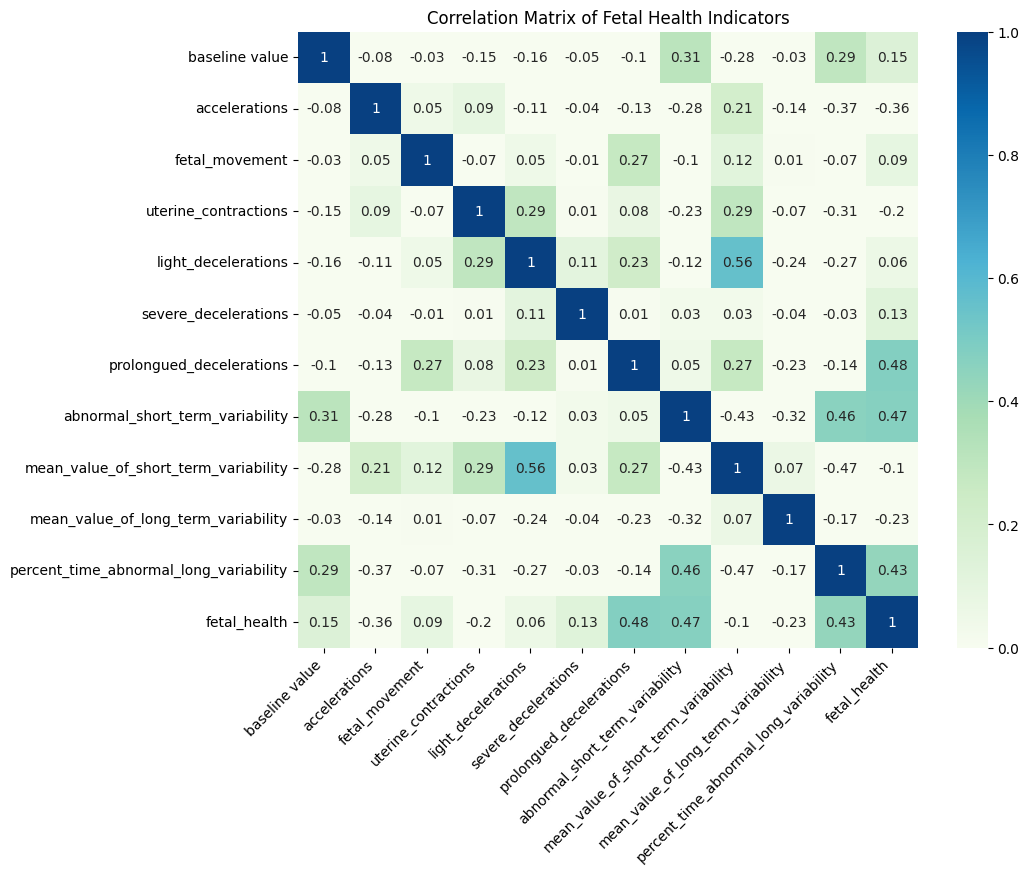

In [17]:
corr = round(feat.corr(), 2)
fig = plt.figure(figsize=(10,8))
axes = fig.subplots()

sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap='GnBu')

plt.title('Correlation Matrix of Fetal Health Indicators')
plt.xticks(ha='right', rotation=45)
plt.show()

### Classifier Analysis


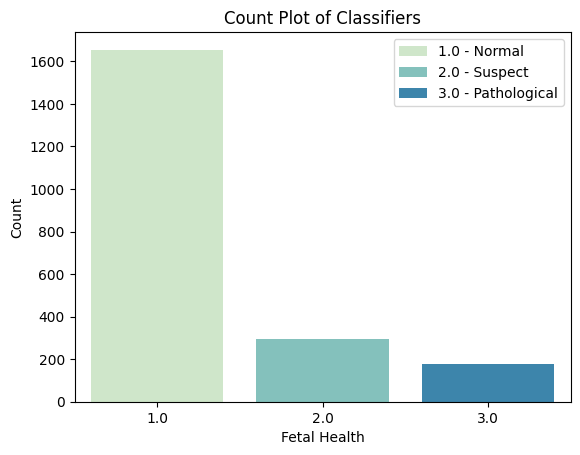

In [18]:
labels = ['1.0 - Normal', '2.0 - Suspect', '3.0 - Pathological']
sns.countplot(data, x='fetal_health', palette='GnBu', label=labels)
plt.title('Count Plot of Classifiers')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.legend()
plt.show()

# Preprocessing

In [19]:
# Scale data with standard scalar
sc = StandardScaler().set_output(transform='pandas')
scaled = sc.fit(X).transform(X)

### Principal Component Analysis


In [20]:
pca = PCA()
pca.fit(scaled)
d = {'Feature':scaled.columns.values, 'PCA Variance Ratio':pca.explained_variance_ratio_}
pca_info = pd.DataFrame(data=d)
l=[]

for z in range(1, len(pca_info['PCA Variance Ratio']) + 1):
  l.append(sum(pca_info['PCA Variance Ratio'].iloc[:z]))

pca_info['Sum PCA Variance'] = l
display(pca_info)

,Feature,PCA Variance Ratio,Sum PCA Variance
0,baseline value,0.250640,0.250640
1,accelerations,0.148219,0.398859
2,fetal_movement,0.107775,0.506633
3,uterine_contractions,0.102701,0.609334
4,light_decelerations,0.089323,0.698657
5,severe_decelerations,0.076052,0.774709
6,prolongued_decelerations,0.066112,0.840821
7,abnormal_short_term_variability,0.059541,0.900362
8,mean_value_of_short_term_variability,0.043945,0.944307
9,mean_value_of_long_term_variability,0.036622,0.980929


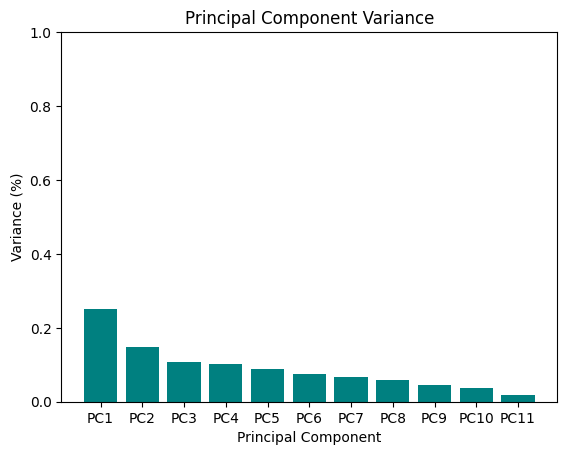

In [21]:
trained_pca = pca.transform(scaled)
var_ratio = pca_info['PCA Variance Ratio']

x=range(0, len(var_ratio))
plt.bar(x, var_ratio, color='teal')
plt.ylabel('Variance (%)')
plt.xlabel('Principal Component')
plt.xticks(x, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'])
plt.ylim([0,1])
plt.title('Principal Component Variance')
plt.show()

### Outlier Detection

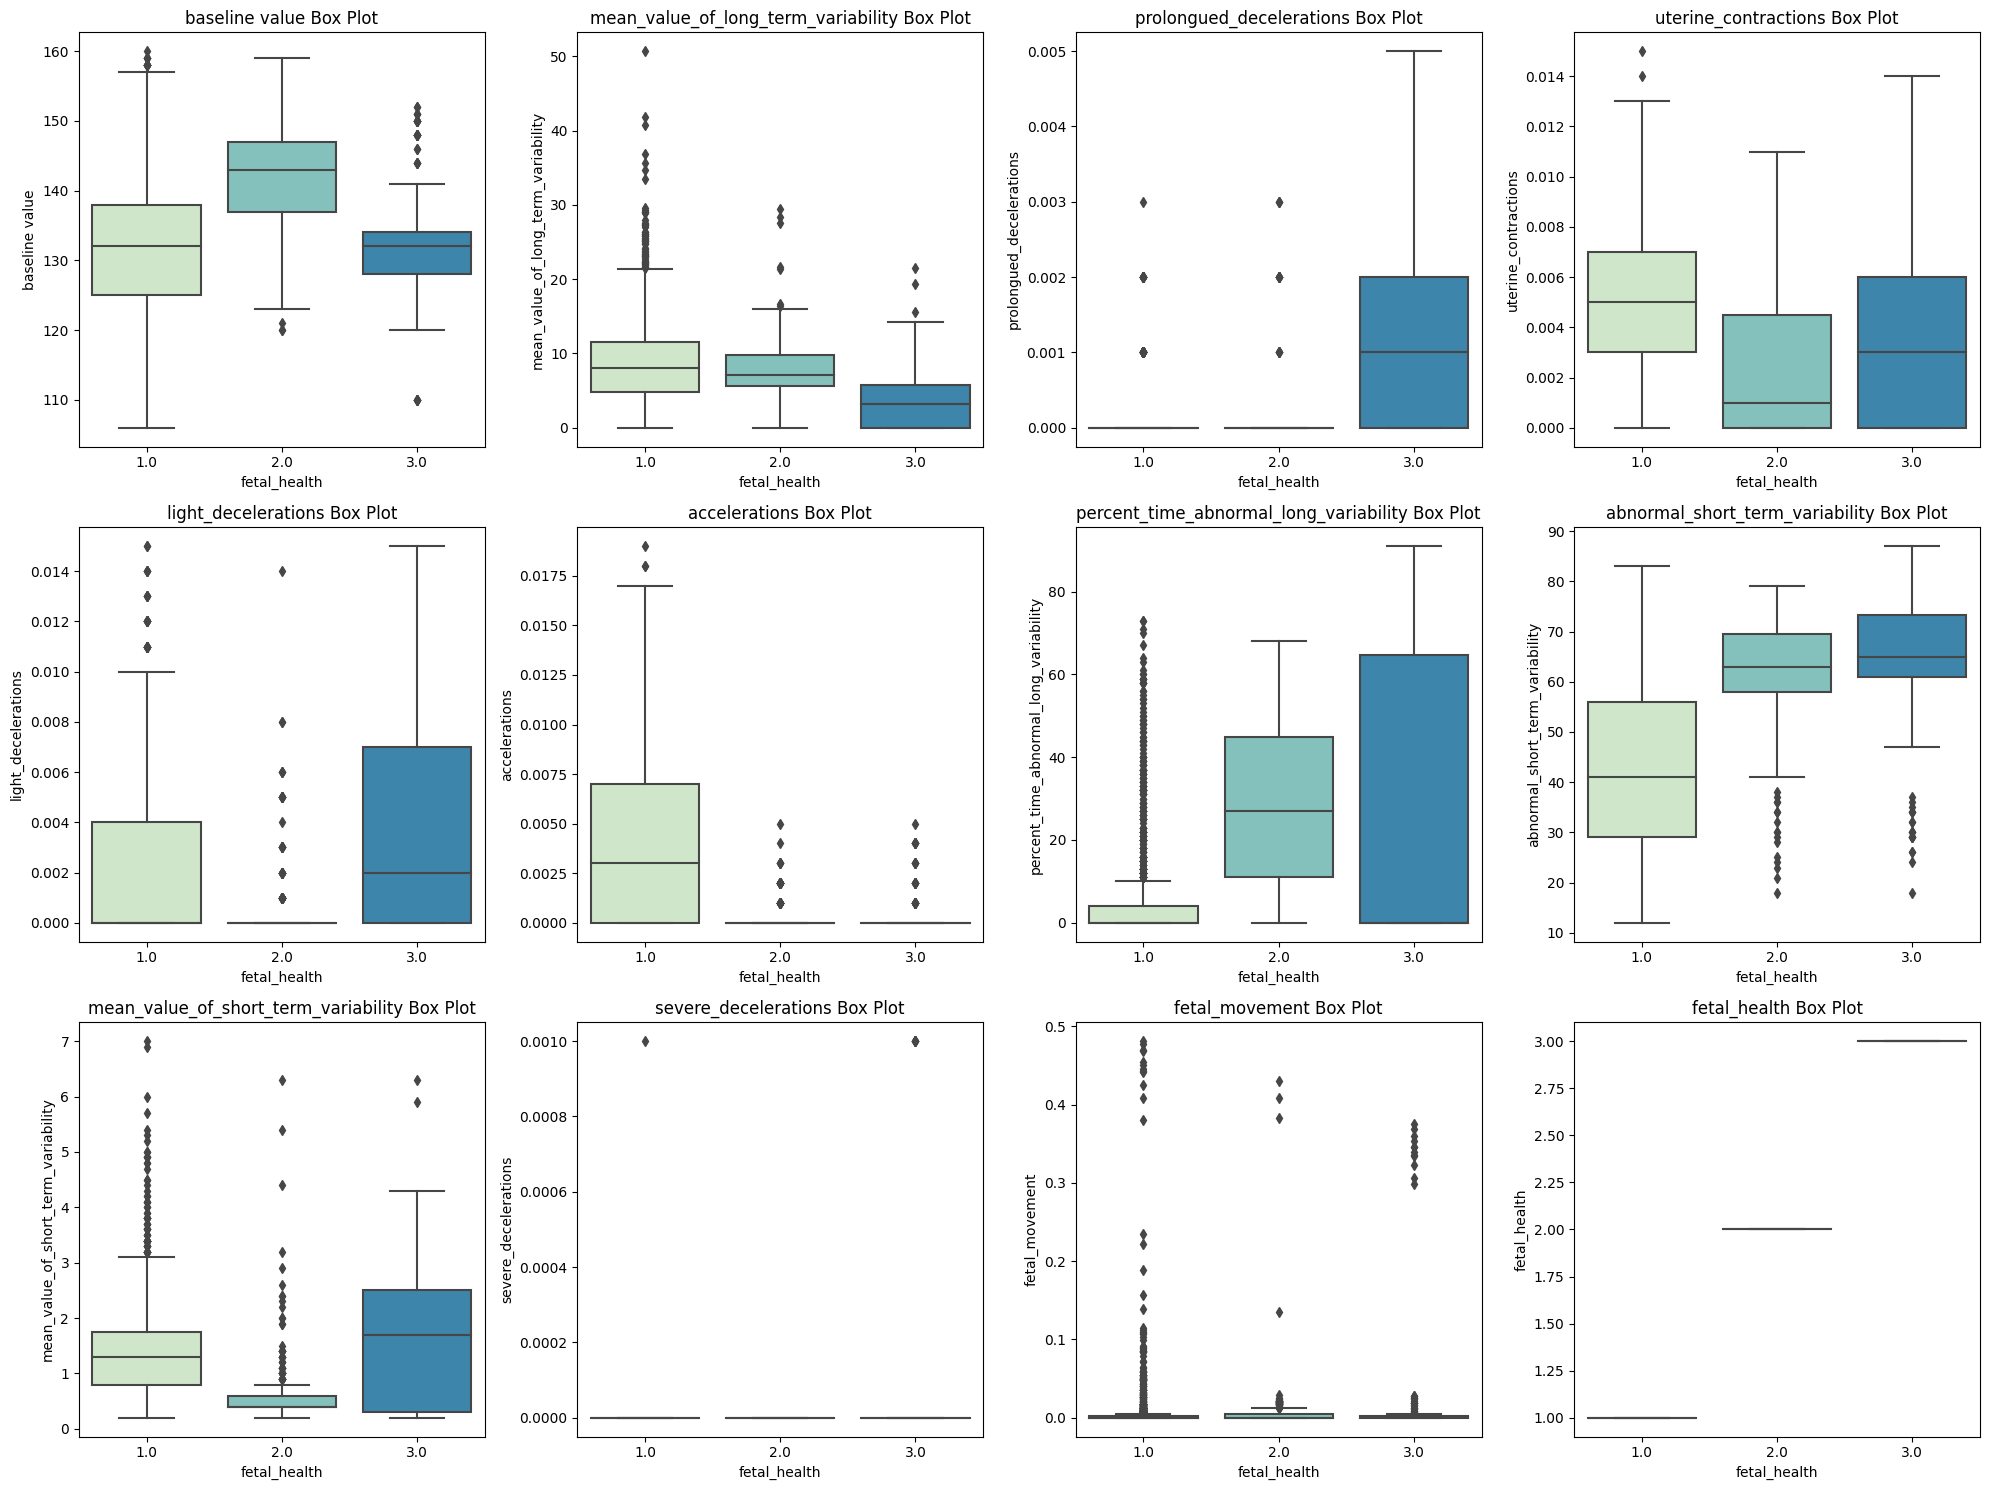

In [22]:
fig = plt.figure(figsize=(20,15))
axes = fig.subplots(3,4)
i = 0
j = 0
for col in feat[:-2]:
  sns.boxplot(x=feat['fetal_health'], 
              y = feat[col], 
              data=feat, 
              ax=axes[i,j], 
              palette='GnBu')
  axes[i,j].set_title(f'{col} Box Plot')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 3: i=0
fig.tight_layout()
plt.show()

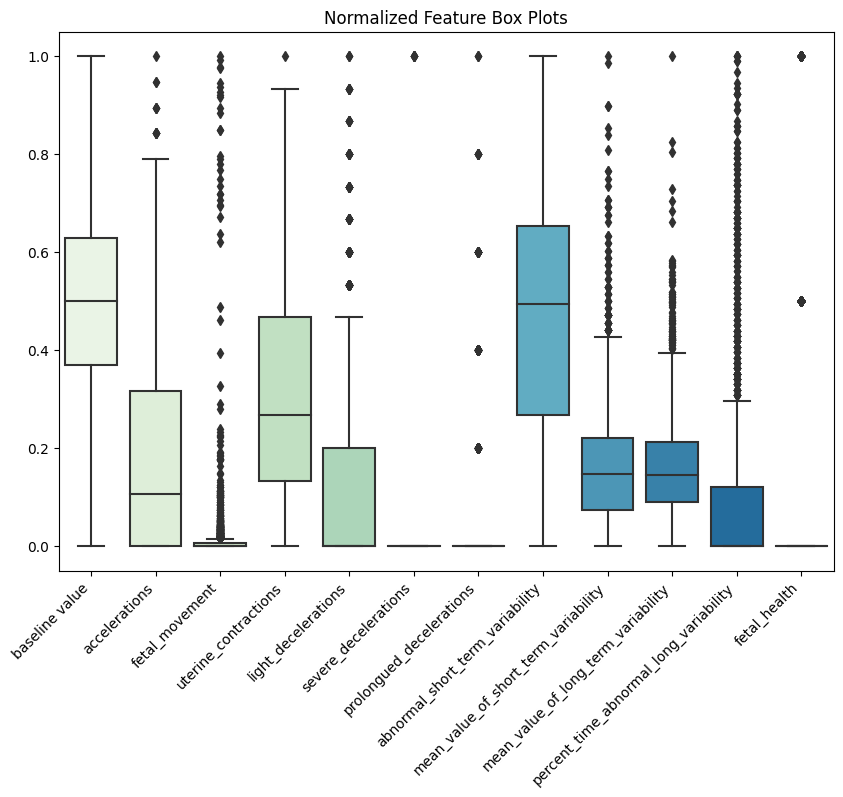

In [23]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')
range_scaled = minmax.fit_transform(feat)
fig = plt.figure(figsize=(10,7))
sns.boxplot(range_scaled,
            palette='GnBu')
plt.title('Normalized Feature Box Plots')
plt.xticks(ha='right',rotation=45)
plt.show()

# Model Selection

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

In [55]:
sc = StandardScaler().set_output(transform='pandas')
X_temp = feat.iloc[:, :-1]
X = sc.fit(X_temp).transform(X_temp).values
y = feat.iloc[:, -1].values
sss = StratifiedShuffleSplit(n_splits=2, 
                           train_size=0.8, 
                           test_size=0.2, 
                           random_state=1234)

for i, (train_index, test_index) in enumerate(sss.split(X, y)):
  X_train = X[train_index]
  y_train = y[train_index]

  X_test = X[test_index]
  y_test = y[test_index]
print(X_train.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1234)

(1700, 11)


In [65]:
model_names = ['Decision Tree',
              'Linear Support Vector Machine',
              'Gradient Boost',
              'k-Nearest Neighbors',
               'Logistic Regression']

dt = DecisionTreeClassifier(class_weight='balanced')

svc = LinearSVC(penalty='l2',
                loss='squared_hinge',
                C=1.0,
                multi_class='ovr',
                class_weight='balanced',
                dual=False)

gb = GradientBoostingClassifier(loss='log_loss',
                                learning_rate=0.1,
                                criterion='friedman_mse')

knn = KNeighborsClassifier(n_neighbors=5,
                           weights='distance',
                           metric='minkowski',
                           p=2)

logreg1 = LogisticRegression(penalty='l1',
                            class_weight='balanced', 
                            multi_class='multinomial',
                            solver='saga')

logreg2 = LogisticRegression(penalty='l2',
                            class_weight='balanced', 
                            multi_class='multinomial',
                            solver='lbfgs')

models = [dt]
# models=[logreg1, logreg2]
# models = [dt, svc, gb, knn, logreg]

In [75]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
tree_param_grid = {'criterion':('gini', 'entropy', 'log_loss'),
                   'splitter':('random', 'best'),
                   'max_features':('sqrt', 'log2'),}
param_grids = [tree_param_grid]

In [82]:
i=0
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
for i in range(len(models)):
  grid = GridSearchCV(estimator=models[i], 
                      param_grid=param_grids[i],
                      scoring='f1_weighted',
                      return_train_score=True)
  grid.fit(X_train, y_train)
  display(pd.DataFrame(grid.cv_results_))
  print(type(models[i]).__name__)
  print(f'The best estimator: {grid.best_estimator_}')
  print(f'The best score: {grid.best_score_}')
  print(f'The best parameters: {grid.best_params_}')
  print(f'The best estimator: {grid.best_estimator_}')
  pred = grid.predict(X_test)
  # ConfusionMatrixDisplay.from_predictions(y_true=y_test, 
  #                                         y_pred=pred,
  #                                         cmap='GnBu')
  # plt.title(f'{model_names[i]} Confusion Matrix')
  # plt.show()
  
  # try:
  #   y_score = model.fit(X_train, y_train).predict_proba(X_test)

  # except:
  #   m = CalibratedClassifierCV(model) 
  #   m.fit(X_train, y_train)
  #   y_score = m.predict_proba(X_test)


  # print(classification_report(y_test, pred))
  # RocCurveDisplay.from_predictions(y_onehot_test.ravel(),
  #                                   y_score.ravel(),
  #                                   name="Micro-Average One-vs-Rest",
  #                                   color="navy")
  # plt.title(f'{model_names[i]} ROC Curve')
  # plt.plot([0, 1], [0, 1], label="chance level (AUC = 0.5)", color='lightgreen', linestyle='--')
  # plt.xlabel("False Positive Rate")
  # plt.ylabel("True Positive Rate")
  # plt.legend()
  # plt.show()
  # i+=1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_splitter,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001795,0.000251,0.001902,0.000917,gini,sqrt,random,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.900726,0.881227,...,0.880361,0.010869,11,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
1,0.002966,0.000352,0.001839,0.000278,gini,sqrt,best,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.895184,0.887230,...,0.908505,0.014472,2,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
2,0.001628,0.000100,0.001266,0.000032,gini,log2,random,"{'criterion': 'gini', 'max_features': 'log2', ...",0.880202,0.856772,...,0.877772,0.016532,12,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
3,0.002637,0.000311,0.001741,0.000556,gini,log2,best,"{'criterion': 'gini', 'max_features': 'log2', ...",0.904623,0.899659,...,0.901098,0.004746,3,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
4,0.001860,0.000174,0.001406,0.000101,entropy,sqrt,random,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.895286,0.872075,...,0.885434,0.009040,10,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
5,0.002707,0.000353,0.001508,0.000256,entropy,sqrt,best,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.894446,0.893459,...,0.896567,0.010322,4,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
6,0.001871,0.000298,0.001354,0.000093,entropy,log2,random,"{'criterion': 'entropy', 'max_features': 'log2...",0.913424,0.878165,...,0.890668,0.014855,8,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
7,0.002511,0.000086,0.001338,0.000020,entropy,log2,best,"{'criterion': 'entropy', 'max_features': 'log2...",0.909570,0.889145,...,0.913559,0.014065,1,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
8,0.001824,0.000158,0.001335,0.000027,log_loss,sqrt,random,"{'criterion': 'log_loss', 'max_features': 'sqr...",0.892968,0.886210,...,0.891894,0.007012,7,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293
9,0.002464,0.000156,0.001477,0.000336,log_loss,sqrt,best,"{'criterion': 'log_loss', 'max_features': 'sqr...",0.884464,0.911931,...,0.895481,0.010357,5,0.999266,0.999266,0.999266,0.999266,0.998533,0.999119,0.000293


DecisionTreeClassifier
The best estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2')
The best score: 0.9135594941585061
The best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'best'}
The best estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2')


In [28]:
# plot_tree(dt)
# plt.show()

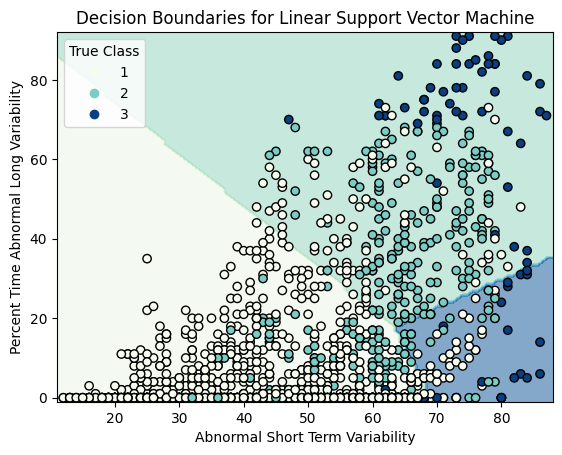

In [29]:
svct = LinearSVC(penalty='l2',
                loss='squared_hinge',
                C=1.0,
                multi_class='ovr',
                class_weight='balanced',
                dual=False)
X_train_corr = X_temp[['abnormal_short_term_variability', 'percent_time_abnormal_long_variability']]

svct.fit(X_train_corr, y)

disp = DecisionBoundaryDisplay.from_estimator(svct,
                                              X_train_corr,
                                              response_method="predict",
                                              alpha=0.5,
                                              xlabel='Abnormal Short Term Variability',
                                              ylabel='Percent Time Abnormal Long Variability',
                                              cmap='GnBu')

decision_function = svct.decision_function(X_train_corr)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train_corr.values[support_vector_indices]

scat = plt.scatter(X_train_corr.iloc[:, 0], 
                    X_train_corr.iloc[:, 1], 
                    c=y, 
                    edgecolors="k", 
                    cmap='GnBu')

# DecisionBoundaryDisplay.from_estimator(svct,
#                                         X_train_corr,
#                                         grid_resolution=50,
#                                         plot_method="contour",
#                                         colors="k",
#                                         levels=[-1, 0, 1],
#                                         alpha=0.5,
#                                         linestyles=["--", "-", "--"])

# plt.scatter(support_vectors[:, 0],
#             support_vectors[:, 1],
#             s=100,
#             linewidth=1,
#             facecolors="none",
#             edgecolors="k")
plt.title('Decision Boundaries for Linear Support Vector Machine')

handles, labels = scat.legend_elements()
plt.legend(handles=handles, labels=labels, title="True Class")

plt.show()

. 
 



.



.



.



.



.



.

In [30]:
# under_df = pd.DataFrame()

# cat1 = feat[feat['fetal_health'] == 1.0]
# cat2 = feat[feat['fetal_health'] == 2.0]
# cat3 = feat[feat['fetal_health'] == 3.0]

# cat1sample = pd.DataFrame(resample(cat1, replace=False, n_samples=len(feat[feat['fetal_health'] == 3.0])))
# cat2sample = pd.DataFrame(resample(cat2, replace=False, n_samples=len(feat[feat['fetal_health'] == 3.0])))

# under_df = pd.concat([cat1sample, cat2sample, cat3]).reset_index(drop=True)

In [31]:
# corr = round(under_df.corr(), 2)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap='GnBu')
# plt.title('Correlation Matrix of Fetal Health Indicators - Under sampled')
# plt.show()

In [32]:
# labels = ['1.0 - Normal', '2.0 - Suspect', '3.0 - Pathological']
# sns.countplot(under_df, x='fetal_health', palette='GnBu', label=labels)
# plt.title('Count Plot of Classifiers - under sample')
# plt.xlabel('Fetal Health')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

In [33]:
# fig = plt.figure(figsize=(20,15))
# axes = fig.subplots(3,4)
# i = 0
# j = 0
# for col in feat[:-2]:
#   sns.boxplot(x=under_df['fetal_health'], 
#               y = under_df[col], 
#               data=under_df, 
#               ax=axes[i,j], 
#               palette='GnBu')
#   plt.xlabel('Fetal Health')
#   axes[i,j].set_title(f'{col} Box Plot - under sampled')
#   i+=1
#   j+=1
#   if j == 4: j=0
#   if i == 3: i=0
# fig.tight_layout()
# plt.show()

In [34]:
# minmax = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')
# range_scaled = minmax.fit_transform(under_df)
# fig = plt.figure(figsize=(10,7))
# sns.boxplot(range_scaled,
#             palette='GnBu')
# plt.title('Range Normalized Feature Box Plots - under sample')
# plt.xticks(ha='right',rotation=45)
# plt.show()

In [35]:
# y = data[['fetal_health']].values
# print('y shape: ', y.shape)
# X = data.iloc[:, :-1]
# print('X shape: ', X.shape)